In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


In [ ]:
device = 'cuda'
lr = 3e-4
z_dim = 64
img_dim = 784
batch_size = 32
num_epochs = 50

In [ ]:
disc = Discriminator(img_dim).to(device)
gen = Generator(z_dim , img_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

In [ ]:
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))]
)
dataset = datasets.MNIST(root = "dataset/" , transform = transforms, download = True)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 259344095.19it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39899767.40it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 143901194.27it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6569147.85it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
opt_disc = optim.Adam(disc.parameters(), lr = lr)
opt_gen = optim.Adam(gen.parameters(), lr = lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real= SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake )/ 2
        disc.zero_grad()
        lossD.backward(retain_graph = True)
        opt_disc.step()

        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/50] Batch 0/1875                       Loss D: 0.0159, loss G: 7.0471
Epoch [1/50] Batch 0/1875                       Loss D: 0.0298, loss G: 5.3999
Epoch [2/50] Batch 0/1875                       Loss D: 0.0064, loss G: 6.3954
Epoch [3/50] Batch 0/1875                       Loss D: 0.0088, loss G: 6.0560
Epoch [4/50] Batch 0/1875                       Loss D: 0.0078, loss G: 5.6417
Epoch [5/50] Batch 0/1875                       Loss D: 0.0364, loss G: 6.6004
Epoch [6/50] Batch 0/1875                       Loss D: 0.0116, loss G: 5.7442
Epoch [7/50] Batch 0/1875                       Loss D: 0.0052, loss G: 6.1224
Epoch [8/50] Batch 0/1875                       Loss D: 0.0093, loss G: 6.3753
Epoch [9/50] Batch 0/1875                       Loss D: 0.0020, loss G: 7.3833
Epoch [10/50] Batch 0/1875                       Loss D: 0.0042, loss G: 6.9620
Epoch [11/50] Batch 0/1875                       Loss D: 0.0142, loss G: 5.8143
Epoch [12/50] Batch 0/1875                       L

## DCGAN

To ensure the stable training of GANs on image data like this, a DCGAN uses three
techniques:

1. Getting rid of fully connected layers and only using convolution layers

2. Using strided convolution layers to perform downsampling, instead of using
pooling layers

3. Using ReLU/leakyReLU activation functions instead of Tanh between hidden
layers

###### Generator Architecture

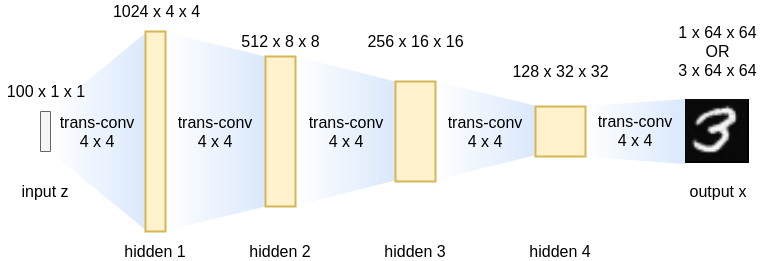


###### Discriminator Architecture

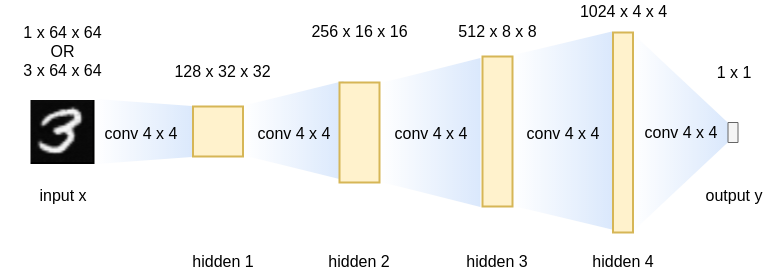

### Creating a DCGAN

In [ ]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import utils

In [ ]:
DATA_PATH = '~Data/mnist'
OUT_PATH = 'output'
LOG_FILE = os.path.join(OUT_PATH,  'log.txt')
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 25
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 3e-4
seed = 2023

In [ ]:
utils.clear_folder(OUT_PATH)
print("Logging tp {}\n".format(LOG_FILE))
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available else "cpu"


Logging tp output/log.txt



## Generator network

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN*8, 4,1,0, bias = False),
            nn.BatchNorm2d(G_HIDDEN*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(G_HIDDEN*8, G_HIDDEN*4, 4,2,1, bias = False),
            nn.BatchNorm2d(G_HIDDEN*4),
            nn.ReLU(True),


            nn.ConvTranspose2d(G_HIDDEN*4, G_HIDDEN*2, 4,2,1, bias = False),
            nn.BatchNorm2d(G_HIDDEN*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(G_HIDDEN*2, G_HIDDEN, 4,2,1, bias = False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),

            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4,2,1,bias = False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator network

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4,2,1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(D_HIDDEN, D_HIDDEN*2, 4,2,1, bias = False),
            nn.BatchNorm2d(D_HIDDEN *2),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(D_HIDDEN*2, D_HIDDEN*4, 4,2,1, bias = False),
            nn.BatchNorm2d(D_HIDDEN *4),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(D_HIDDEN*4, D_HIDDEN*8, 4,2,1, bias = False),
            nn.BatchNorm2d(D_HIDDEN *8),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(D_HIDDEN*8 , 1,4,1,0 , bias = False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1,1).squeeze(1)

In [ ]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
dataset = dset.MNIST(root=DATA_PATH, download=True,
                        transform=transforms.Compose([
                        transforms.Resize(X_DIM),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                        ]))
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 164335421.31it/s]

Extracting ~Data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ~Data/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108447353.47it/s]


Extracting ~Data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ~Data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72674163.24it/s]

Extracting ~Data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ~Data/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2635657.00it/s]


Extracting ~Data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ~Data/mnist/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device = device)
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader):
        x_real = data[0].to(device)
        real_label = torch.full((x_real.size(0),), REAL_LABEL,device = device)
        fake_label = torch.full((x_real.size(0),), FAKE_LABEL, device=device)

        netD.zero_grad()
        y_real = netD(x_real)
        loss_D_real = criterion(y_real.type(torch.float32), real_label.type(torch.float32))

        z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
        x_fake = netG(z_noise)
        y_fake = netD(x_fake.detach())
        loss_D_fake = criterion(y_fake.type(torch.float32), fake_label.type(torch.float32))
        loss_D_fake.backward()
        optimizerD.step()

        netG.zero_grad()
        y_fake_r = netD(x_fake)
        loss_G = criterion(y_fake_r.type(torch.float32), real_label.type(torch.float32))
        loss_G.backward()
        optimizerG.step()

        if i % 100 == 0:
            print('Epoch {} [{}/{}] loss_D_real: {:.4f} loss_D_fake:{:.4f} loss_G: {:.4f}'.format(
                epoch, i, len(dataloader),
                loss_D_real.mean().item(),
                loss_D_fake.mean().item(),
                loss_G.mean().item()
            ))
            vutils.save_image(x_real, os.path.join(OUT_PATH,'real_samples.png'), normalize=True)
            with torch.no_grad():
                viz_sample = netG(viz_noise)
                vutils.save_image(viz_sample, os.path.join(OUT_PATH,'fake_samples_{}.png'.format(epoch)), normalize=True)
                torch.save(netG.state_dict(), os.path.join(OUT_PATH,'netG_{}.pth'.format(epoch)))
                torch.save(netD.state_dict(), os.path.join(OUT_PATH,'netD_{}.pth'.format(epoch)))

Epoch 0 [0/469] loss_D_real: 24.1744 loss_D_fake:0.0000 loss_G: 43.7683
Epoch 0 [100/469] loss_D_real: 24.2432 loss_D_fake:0.0000 loss_G: 43.7921
Epoch 0 [200/469] loss_D_real: 24.3143 loss_D_fake:0.0000 loss_G: 43.7340
Epoch 0 [300/469] loss_D_real: 24.0366 loss_D_fake:0.0000 loss_G: 43.6752
Epoch 0 [400/469] loss_D_real: 24.1280 loss_D_fake:0.0000 loss_G: 43.6447
Epoch 1 [0/469] loss_D_real: 24.3157 loss_D_fake:0.0000 loss_G: 43.5967
Epoch 1 [100/469] loss_D_real: 23.9346 loss_D_fake:0.0000 loss_G: 43.6387
Epoch 1 [200/469] loss_D_real: 24.3143 loss_D_fake:0.0000 loss_G: 43.6291
Epoch 1 [300/469] loss_D_real: 24.4092 loss_D_fake:0.0000 loss_G: 43.6826
Epoch 1 [400/469] loss_D_real: 24.3104 loss_D_fake:0.0000 loss_G: 43.5338
Epoch 2 [0/469] loss_D_real: 24.3438 loss_D_fake:0.0000 loss_G: 43.5481
Epoch 2 [100/469] loss_D_real: 24.2426 loss_D_fake:0.0000 loss_G: 43.5500
Epoch 2 [200/469] loss_D_real: 24.2883 loss_D_fake:0.0000 loss_G: 43.5517
Epoch 2 [300/469] loss_D_real: 24.3105 loss_